Virtual environment for this notebook (since needs Python version 3.12 in order to run tensorflow as of 05/2025). 

Run the following in the terminal:
source py312-jupyter/bin/activate
jupyter notebook

Import relevant modules

In [1]:
!python3 --version

Python 3.12.10


In [2]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# For reproducibility
import random
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


2025-05-07 16:58:39.649527: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Import dataset

Dataset from: https://www.kaggle.com/datasets/sinamhd9/concrete-comprehensive-strength/data

In [3]:
# Load from Excel file
df = pd.read_excel("concrete_data.xls")

# Sanity check
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
# Separate features and target variable
X_full = df.iloc[:, :-1].values  # All columns except the last one (input features)
y_full = df.iloc[:, -1].values  # Last column (target variable - concrete compressive strength)

# Split into train, cross-validation, and test sets (60%, 20%, 20%)
X_train_full, X_temp, y_train_unscaled, y_temp = train_test_split(X_full, y_full, test_size=0.4, random_state=seed)
X_cv, X_test, y_cv_unscaled, y_test_unscaled = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)


Normalize features

In [5]:
# Normalize input features (X)
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train_full)
X_cv = scaler_X.transform(X_cv)
X_test = scaler_X.transform(X_test)

# Normalize target variable (y)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_unscaled.reshape(-1, 1))
y_cv_scaled = scaler_y.transform(y_cv_unscaled.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_unscaled.reshape(-1, 1))

Model training with hyperparameter search

In [6]:
# Hyperparameters to explore
layer_options = [1, 2, 3]
poly_degrees = [1, 2]
lambda_values = [0.001, 0.01, 0.1]

# To store results
results = []

# Hyperparameter tuning
for degree in poly_degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    
    # Apply polynomial feature transformation
    X_train_poly = poly.fit_transform(X_train)
    X_cv_poly = poly.transform(X_cv)

    input_dim = X_train_poly.shape[1]
    
    for layers in layer_options:
        for lam in lambda_values:
            # Build model
            model = Sequential()
            model.add(Input(shape=(input_dim,)))
            model.add(Dense(64, activation='relu', kernel_regularizer=l2(lam)))
            for _ in range(layers - 1):
                model.add(Dense(64, activation='relu', kernel_regularizer=l2(lam)))
            model.add(Dense(1))  # Output layer

            model.compile(optimizer='adam', loss='mse')

            # Early stopping
            early_stop = EarlyStopping(patience=10, restore_best_weights=True)
            
            # Train model
            history = model.fit(
                X_train_poly, y_train_scaled, 
                validation_data=(X_cv_poly, y_cv_scaled),
                epochs=100, verbose=0,
                callbacks=[early_stop]
            )
            
            # Evaluate
            y_train_pred_scaled = model.predict(X_train_poly)
            y_cv_pred_scaled = model.predict(X_cv_poly)

            Jtrain = mean_squared_error(y_train_scaled, y_train_pred_scaled)
            Jcv = mean_squared_error(y_cv_scaled, y_cv_pred_scaled)

            results.append({
                'degree': degree,
                'layers': layers,
                'lambda': lam,
                'Jtrain': Jtrain,
                'Jcv': Jcv,
                'model': model,
                'poly': poly
            })

# Sort by CV error
results.sort(key=lambda x: x['Jcv'])

# Display top models
results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'model' and k != 'poly'} for r in results])
print(results_df.head())

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━

Select best model and evaluate learning curve

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


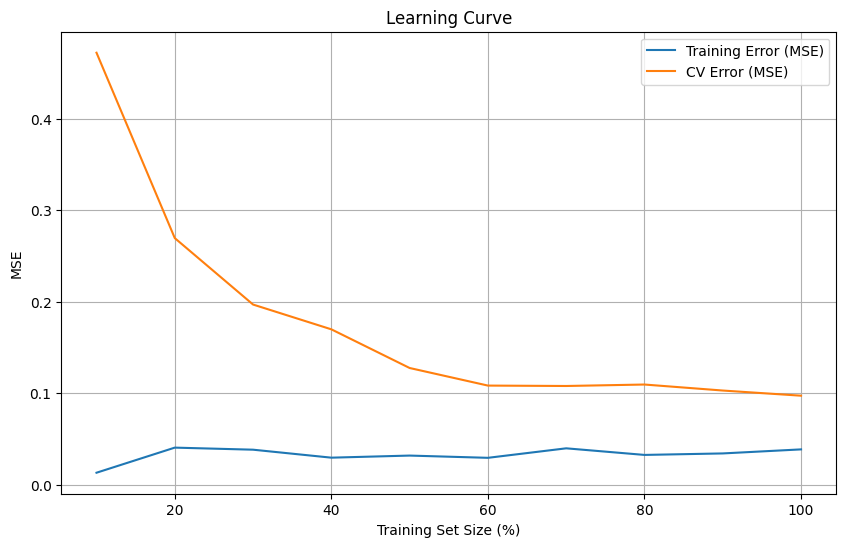

In [7]:
# Select best model (with lowest CV error)
best = results[0]
best_model = best['model']
best_poly = best['poly']

# For learning curve
train_sizes = np.linspace(0.1, 1.0, 10)
train_errors = []
cv_errors = []

X_train_poly = best_poly.transform(X_train)
X_cv_poly = best_poly.transform(X_cv)

for frac in train_sizes:
    frac = min(frac, 0.999999)  # Prevent invalid 1.0 split
    X_sub, _, y_sub, _ = train_test_split(X_train_poly, y_train_scaled, train_size=frac, random_state=42)
    
    model = Sequential()
    model.add(Input(shape=(X_sub.shape[1],)))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(best['lambda'])))
    for _ in range(best['layers'] - 1):
        model.add(Dense(64, activation='relu', kernel_regularizer=l2(best['lambda'])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_sub, y_sub, epochs=100, verbose=0)
    
    y_sub_pred_scaled = model.predict(X_sub)
    y_cv_pred_scaled = model.predict(X_cv_poly)

    train_errors.append(mean_squared_error(y_sub, y_sub_pred_scaled))
    cv_errors.append(mean_squared_error(y_cv_scaled, y_cv_pred_scaled))

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes * 100, train_errors, label="Training Error (MSE)")
plt.plot(train_sizes * 100, cv_errors, label="CV Error (MSE)")
plt.xlabel("Training Set Size (%)")
plt.ylabel("MSE")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


Final test set evaluation

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Training Set Evaluation:
- MSE: 10.591
- MAE: 2.400
- R² Score: 0.960

Cross-Validation Set Evaluation:
- MSE: 26.938
- MAE: 3.734
- R² Score: 0.910

Test Set Evaluation:
- MSE: 34.075
- MAE: 4.236
- R² Score: 0.883


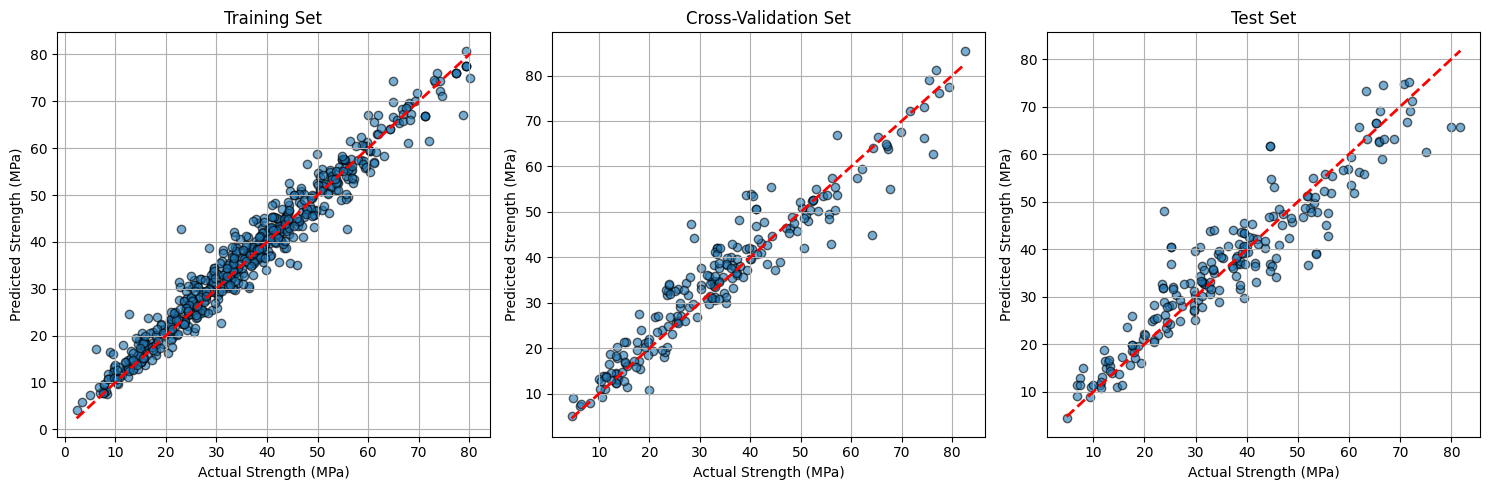

In [8]:
# Transform features using the best polynomial transformer
X_train_poly = best_poly.transform(X_train)
X_cv_poly = best_poly.transform(X_cv)
X_test_poly = best_poly.transform(X_test)

# Predict with best model
y_train_pred_scaled = best_model.predict(X_train_poly)
y_cv_pred_scaled = best_model.predict(X_cv_poly)
y_test_pred_scaled = best_model.predict(X_test_poly)

# Inverse-transform predictions and true values
y_train_true = scaler_y.inverse_transform(y_train_scaled)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

y_cv_true = scaler_y.inverse_transform(y_cv_scaled)
y_cv_pred = scaler_y.inverse_transform(y_cv_pred_scaled)

y_test_true = scaler_y.inverse_transform(y_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# Define evaluation function
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{label} Set Evaluation:")
    print(f"- MSE: {mse:.3f}")
    print(f"- MAE: {mae:.3f}")
    print(f"- R² Score: {r2:.3f}")

# Evaluate all sets
evaluate(y_train_true, y_train_pred, "Training")
evaluate(y_cv_true, y_cv_pred, "Cross-Validation")
evaluate(y_test_true, y_test_pred, "Test")

# Plot predicted vs actual for all sets
plt.figure(figsize=(15, 5))

for i, (true, pred, title) in enumerate([
    (y_train_true, y_train_pred, "Training Set"),
    (y_cv_true, y_cv_pred, "Cross-Validation Set"),
    (y_test_true, y_test_pred, "Test Set")
]):
    plt.subplot(1, 3, i+1)
    plt.scatter(true, pred, alpha=0.6, edgecolors='k')
    plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--', lw=2)
    plt.xlabel("Actual Strength (MPa)")
    plt.ylabel("Predicted Strength (MPa)")
    plt.title(title)
    plt.grid(True)

plt.tight_layout()
plt.show()

The red dashed line showing perfect prediction (y = ŷ). Points close to that line indicate good model performance.